In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3


from dateutil.parser import parse
from datetime import datetime

from math import radians, cos, sin, asin, sqrt

from scipy import stats
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import scale
from sklearn.preprocessing import MinMaxScaler

In [2]:
conn = sqlite3.connect("house.db")
c = conn.cursor()
c.execute("SELECT name FROM sqlite_master WHERE type='table' ORDER BY name;")
c.fetchall()

[('houseprice',)]

In [3]:
house = pd.read_sql("SELECT * FROM houseprice;", conn)

house.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,overall_grade,sqft_above,sqft_basement,year_built,year_renovated,zipcode,latitude,longitude,sqft_living15,sqft_lot15
0,1453602313,20141029T000000,297000.0,2,1.50,1430,1650,3.0,0.0,0,...,7.0,1430,0.0,1999,0,98125,47.7222,-122.290,1430,1650
1,2225059214,20140808T000000,1580000.0,4,3.25,4670,51836,2.0,0.0,0,...,12.0,4670,0.0,1988,0,98005,47.6350,-122.164,4230,41075
2,2768000270,20140625T000000,562100.0,2,0.75,1440,3700,1.0,0.0,0,...,7.0,1200,240.0,1914,0,98107,47.6707,-122.364,1440,4300
3,6819100040,20140624T000000,631500.0,2,1.00,1130,2640,1.0,0.0,0,...,8.0,1130,0.0,1927,0,98109,47.6438,-122.357,1680,3200
4,4027700666,20150426T000000,780000.0,4,2.50,3180,9603,2.0,0.0,2,...,9.0,3180,0.0,2002,0,98155,47.7717,-122.277,2440,15261


# Task 1

In [4]:
# def fill_missing(house):
#     """
#     """
#     print(house.isnull().sum(axis=0))
#     print(house.columns[house.isnull().sum() > 0])
    
#     for col in ['floors', 'waterfront', 'condition', 'overall_grade']:
#         house[col].fillna(house[col].mean(), inplace=True)
    
#     house['sqft_basement'].fillna(0, inplace=True)
    
#     return house
    
# def convert_data(house):
#     """
    
#     """
    
#     parser = lambda x: (datetime.today().date() - parse(x[:8]).date()).days
#     house["sold_time_delta"] = house["date"].apply(parser)
#     house.drop(["date"], axis=1, inplace=True)
    
    
#     loc_space_needle = (47.620810, -122.348565)
#     house["dist_Seattle"] = pd.Series([haversine(loc_space_needle[0], loc_space_needle[1], house["latitude"][i], house["longitude"][i]) 
#                                        for i in range(len(house["latitude"]))])
#     house.drop(["latitude", "longitude"], axis=1, inplace=True)

#     return house
    

# def remove_outliers(house):
#     """
    
#     """
#     TARGET = "price"
#     subplot_scatter(house, TARGET)
#     subplot_box(house, TARGET)
#     house = iqr_drop_missing(house)
#     subplot_scatter(house, TARGET)
#     subplot_box(house, TARGET)
    
#     return house

In [5]:
# def preprocessing(house):
#     house = fill_missing(house)
#     house = convert_data(house)
#     house = remove_outliers(house)
#     return house

# house = preprocessing(house)

## drop unrelated columns

In [6]:
house.drop(["id", "zipcode"], axis=1, inplace=True)

## fill_missing

In [7]:
house.isnull().sum(axis=0)

date               0
price              0
bedrooms           0
bathrooms          0
sqft_living        0
sqft_lot           0
floors            81
waterfront        76
view               0
condition         72
overall_grade     90
sqft_above         0
sqft_basement     70
year_built         0
year_renovated     0
latitude           0
longitude          0
sqft_living15      0
sqft_lot15         0
dtype: int64

In [8]:
house.columns[house.isnull().sum() > 0]

Index(['floors', 'waterfront', 'condition', 'overall_grade', 'sqft_basement'], dtype='object')

In [9]:
for col in ['floors', 'condition', 'overall_grade']:
    house[col].fillna(house[col].mean(), inplace=True)

for col in ['sqft_basement', 'waterfront']:
    house[col].fillna(0, inplace=True)

In [10]:
# date

parser = lambda x: (datetime.today().date() - parse(x[:8]).date()).days

house["sold_day_delta"] = house["date"].apply(parser)
house.drop(["date"], axis=1, inplace=True)


# latitude & longitude

def haversine(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r


loc_Columbia_Center = (47.604603, -122.330702)
house["dist_Seattle"] = pd.Series([haversine(loc_Columbia_Center[0], loc_Columbia_Center[1], house["latitude"][i], house["longitude"][i]) for i in range(len(house["latitude"]))])
house.drop(["latitude", "longitude"], axis=1, inplace=True)


# view & sqft_basement

for col in ['view', 'sqft_basement']:
    house[col][house[col] > 0] = 1
    # pd.crosstab(index=house[col], columns=col)

# year_renovated

index = house["year_renovated"] == 0
house["year_renovated"][index] = house["year_built"][index]
house["year_renovated"] = 2019 - house["year_renovated"]
house["year_built"] = 2019 - house["year_built"]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [11]:
house

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,overall_grade,sqft_above,sqft_basement,year_built,year_renovated,sqft_living15,sqft_lot15,sold_day_delta,dist_Seattle
0,297000.0,2,1.50,1430,1650,3.000000,0.0,0,3.000000,7.000000,1430,0.0,20,20,1430,1650,1790,8.326675
1,1580000.0,4,3.25,4670,51836,2.000000,0.0,0,4.000000,12.000000,4670,0.0,31,31,4230,41075,1872,18.623943
2,562100.0,2,0.75,1440,3700,1.000000,0.0,0,3.000000,7.000000,1200,1.0,105,105,1440,4300,1916,5.401209
3,631500.0,2,1.00,1130,2640,1.000000,0.0,0,4.000000,8.000000,1130,0.0,92,92,1680,3200,1917,3.740087
4,780000.0,4,2.50,3180,9603,2.000000,0.0,1,3.000000,9.000000,3180,0.0,17,17,2440,15261,1611,11.586735
5,485000.0,3,2.50,1650,3436,2.000000,0.0,0,3.000000,7.000000,1650,0.0,16,16,1680,3446,1629,33.087594
6,340000.0,3,2.75,1720,28000,1.000000,0.0,0,4.000000,7.000000,1720,0.0,61,61,2000,41817,1671,19.855433
7,335606.0,3,2.50,2538,4600,2.000000,0.0,0,3.000000,8.000000,2538,0.0,6,6,2570,4800,1903,25.428923
8,425000.0,4,2.50,2460,5440,2.000000,0.0,0,3.000000,9.000000,2460,0.0,16,16,2460,5124,1630,25.098729
9,490000.0,5,3.50,4460,2975,3.000000,0.0,1,3.000000,10.000000,3280,1.0,4,4,2490,4231,1952,4.649499


## remove_outliers

In [12]:
def _scatter(df, feature, target):
    """
    
    """
    #plt.figure(figsize=(16,8))
    plt.scatter(df[feature], df[target])
    plt.xlabel(feature)
    plt.ylabel(target)
    
    items = [feature, " vs ", target]
    title = ''.join(items)
    plt.title(title)

    
def subplot_scatter(df, target):
    """
    
    """
    
    plt.figure(figsize=(30,90))
    num_subplot = len(df.columns.drop(target))
    for i, col in enumerate(house.columns.drop(target)):
        plt.subplot(num_subplot//2 + 1,2,i+1)
        _scatter(df, col, target)
        
def subplot_box(df):
    """
    
    """
    
    plt.figure(figsize=(30,90))
    num_subplot = len(df.columns)
    for i, col in enumerate(house.columns):
        plt.subplot(num_subplot//2 + 1,2,i+1)
        sns.boxplot(x=df[col])

        
def get_status(x) : 
    return pd.DataFrame([x.median(),x.mad(),x.var(),x.std(),x.skew(),x.kurt()],
                        index=['median','mad','var','std','skew','kurt']).round(3)

     
        
TARGET = "price"

In [13]:
house.describe().round(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,overall_grade,sqft_above,sqft_basement,year_built,year_renovated,sqft_living15,sqft_lot15,sold_day_delta,dist_Seattle
count,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000,18371.000
mean,540939.874,3.375,2.115,2082.128,15086.493,1.493,0.007,0.100,3.409,7.658,1789.571,0.393,47.975,45.630,1988.427,12808.836,1788.799,18.020
std,370060.562,0.934,0.769,920.244,40143.679,0.538,0.086,0.299,0.650,1.176,828.351,0.488,29.298,28.743,688.678,26805.558,113.140,12.872
min,75000.000,0.000,0.000,290.000,520.000,1.000,0.000,0.000,1.000,1.000,290.000,0.000,4.000,4.000,399.000,651.000,1580.000,1.218
25%,321000.000,3.000,1.750,1430.000,5046.500,1.000,0.000,0.000,3.000,7.000,1200.000,0.000,22.000,20.000,1490.000,5100.000,1678.000,7.390
50%,450000.000,3.000,2.250,1920.000,7620.000,1.500,0.000,0.000,3.000,7.000,1560.000,0.000,44.000,42.000,1840.000,7632.000,1802.000,15.899
75%,645000.000,4.000,2.500,2550.000,10699.000,2.000,0.000,0.000,4.000,8.000,2210.000,1.000,67.000,65.000,2360.000,10097.000,1889.000,24.174
max,7700000.000,33.000,8.000,13540.000,1164794.000,3.500,1.000,1.000,5.000,13.000,9410.000,1.000,119.000,119.000,6210.000,871200.000,1970.000,113.114


In [14]:
get_status(house)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,overall_grade,sqft_above,sqft_basement,year_built,year_renovated,sqft_living15,sqft_lot15,sold_day_delta,dist_Seattle
median,4.500000e+05,3.000,2.250,1920.000,7.620000e+03,1.500,0.000,0.000,3.000,7.000,1560.000,0.000,44.000,42.000,1840.000,7.632000e+03,1802.000,15.899
mad,2.350203e+05,0.735,0.614,698.680,1.378652e+04,0.486,0.015,0.179,0.559,0.928,640.480,0.477,24.490,23.969,538.362,1.015886e+04,98.601,10.073
var,1.369448e+11,0.873,0.591,846849.590,1.611515e+09,0.290,0.007,0.090,0.423,1.384,686165.526,0.238,858.370,826.165,474277.365,7.185379e+08,12800.666,165.700
std,3.700606e+05,0.934,0.769,920.244,4.014368e+04,0.538,0.086,0.299,0.650,1.176,828.351,0.488,29.298,28.743,688.678,2.680556e+04,113.140,12.872
skew,4.118000e+00,2.220,0.516,1.500,1.165000e+01,0.621,11.494,2.674,1.031,0.767,1.454,0.440,0.470,0.557,1.120,8.803000e+00,-0.167,1.324
kurt,3.656400e+01,56.532,1.370,5.551,2.095400e+02,-0.465,130.124,5.151,0.559,1.204,3.488,-1.807,-0.653,-0.522,1.645,1.247340e+02,-1.283,2.763


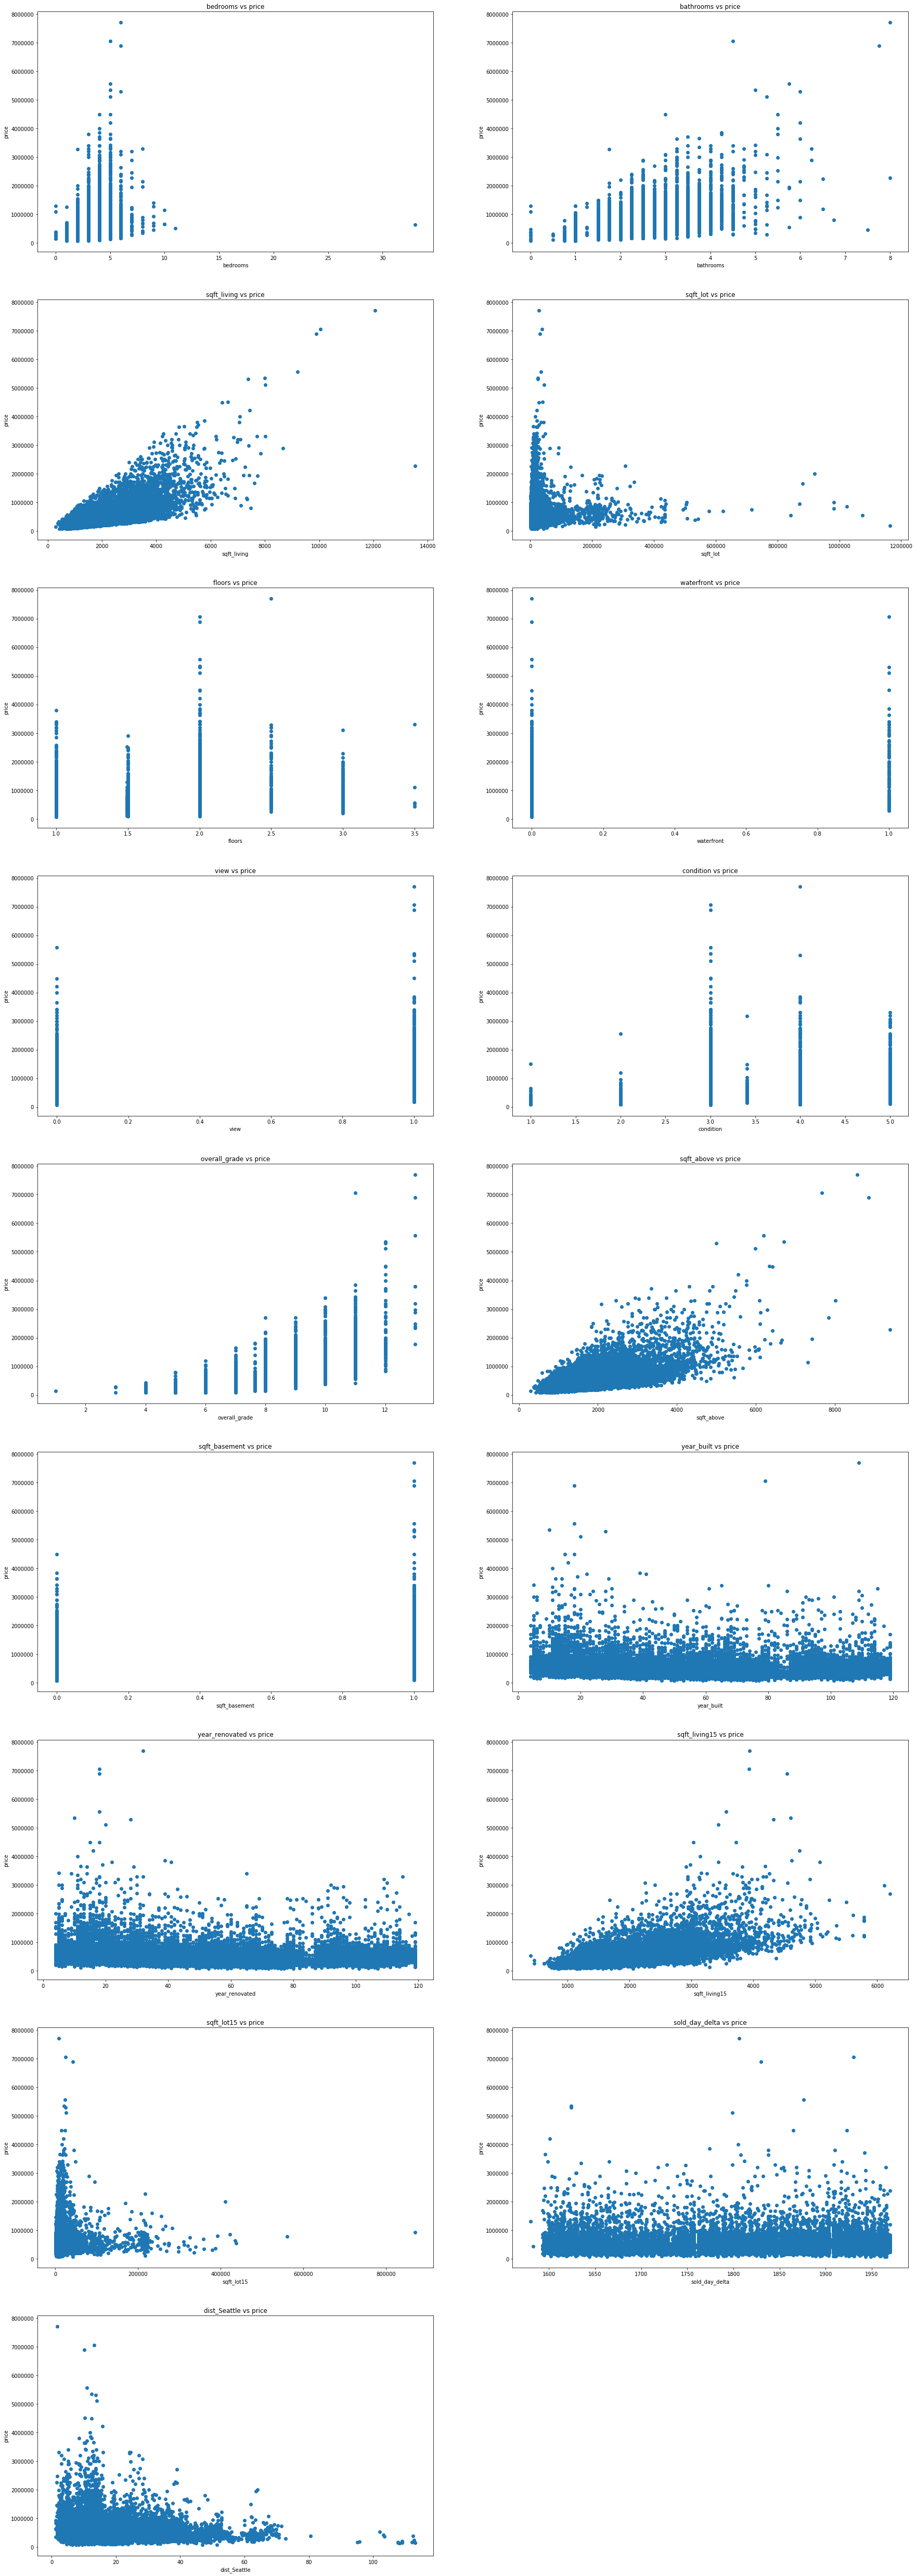

In [15]:
subplot_scatter(house, TARGET)

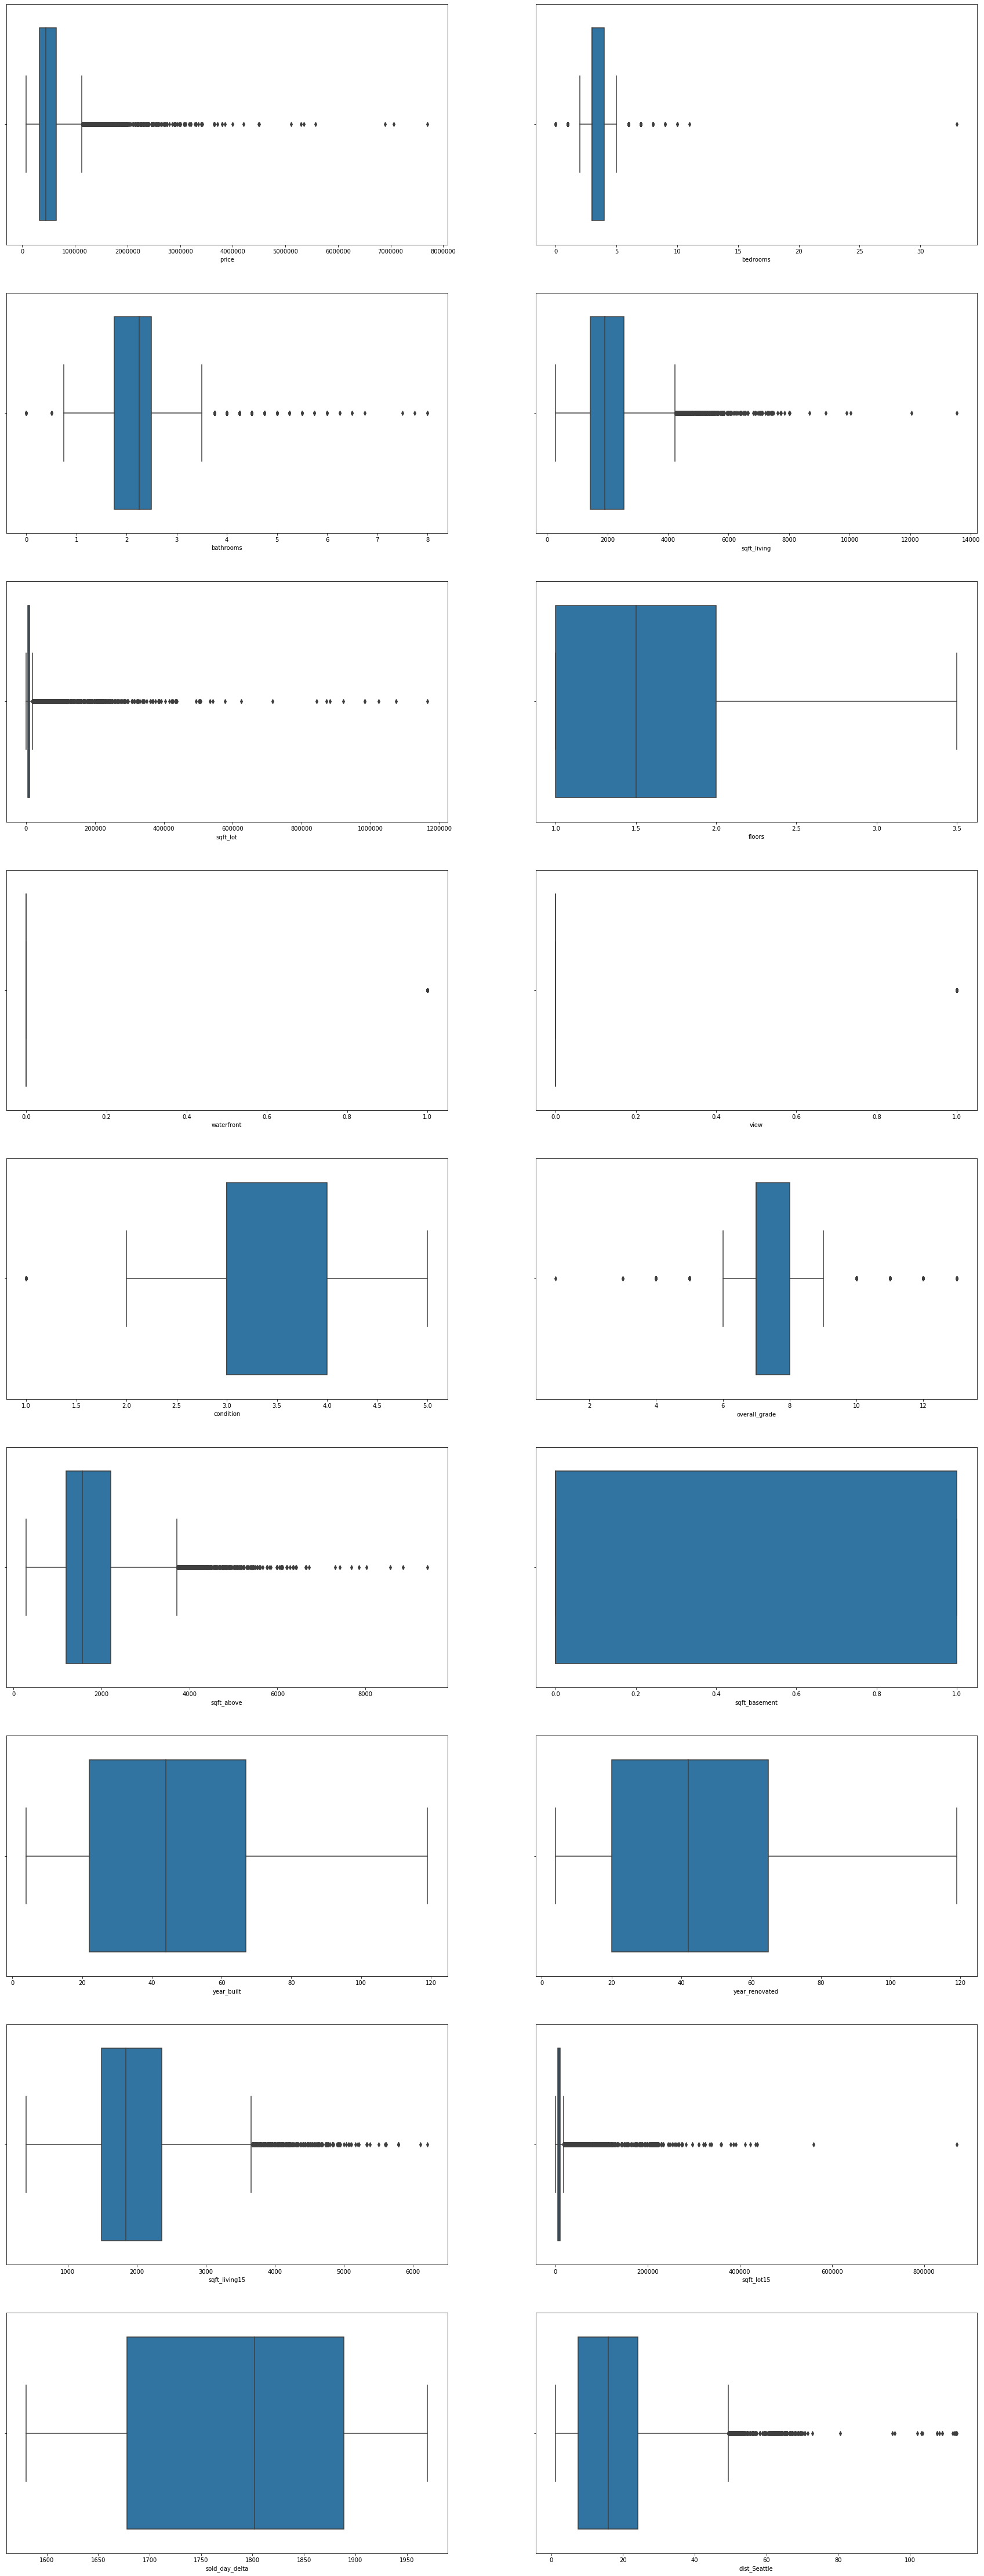

In [16]:
subplot_box(house)

In [17]:
def zscore_drop_missing(df, col_list,THRESHOLD):
    """
    """
    z = np.abs(stats.zscore(df))
    #THRESHOLD = 3
    df = df[(z < THRESHOLD).all(axis=1)]
    df.index = range(len(df))

# zscore_drop_missing(df)

def iqr_drop_missing(df, col_list,THRESHOLD ):
    """
    
    """
    for col in col_list:
        series = df[col]
        print(col)
        temp = len(df)
        Q1 = series.quantile(0.25)
        Q3 = series.quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((series < (Q1 - THRESHOLD * IQR)) |(series > (Q3 + THRESHOLD * IQR)))]
        df.index = range(len(df))
        print(temp - len(df) )
        
    return df

In [18]:
# numeric 的才 IQR 

col_list = ["price", "bedrooms", "bathrooms", "sqft_living", "sqft_lot", "floors","condition", "sqft_above", 
            "year_built", "year_renovated", "sqft_living15", "sqft_lot15", "sold_day_delta", "dist_Seattle"]

house = iqr_drop_missing(house, col_list, 8)

price
28
bedrooms
1
bathrooms
0
sqft_living
1
sqft_lot
661
floors
0
condition
0
sqft_above
0
year_built
0
year_renovated
0
sqft_living15
0
sqft_lot15
172
sold_day_delta
0
dist_Seattle
0


In [19]:
house.describe().round(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,overall_grade,sqft_above,sqft_basement,year_built,year_renovated,sqft_living15,sqft_lot15,sold_day_delta,dist_Seattle
count,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000,17508.000
mean,530586.223,3.371,2.098,2045.626,9084.100,1.493,0.007,0.097,3.410,7.629,1754.641,0.397,48.420,46.072,1963.747,8615.317,1788.798,17.215
std,335770.085,0.908,0.752,867.831,7539.448,0.541,0.080,0.296,0.651,1.143,782.648,0.489,29.532,29.024,672.880,6548.506,113.036,12.323
min,75000.000,0.000,0.000,290.000,520.000,1.000,0.000,0.000,1.000,1.000,290.000,0.000,4.000,4.000,460.000,651.000,1580.000,1.218
25%,319000.000,3.000,1.500,1410.000,5000.000,1.000,0.000,0.000,3.000,7.000,1180.000,0.000,22.000,20.000,1470.000,5001.000,1678.000,7.226
50%,447000.000,3.000,2.250,1890.000,7439.000,1.500,0.000,0.000,3.000,7.000,1540.000,0.000,45.000,42.000,1820.000,7500.000,1802.000,15.050
75%,635000.000,4.000,2.500,2510.000,10005.250,2.000,0.000,0.000,4.000,8.000,2160.000,1.000,68.000,65.000,2330.000,9682.000,1889.000,23.242
max,3200000.000,11.000,7.500,7620.000,55387.000,3.500,1.000,1.000,5.000,13.000,6290.000,1.000,119.000,119.000,6110.000,47480.000,1970.000,113.114


In [20]:
get_status(house)  

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,overall_grade,sqft_above,sqft_basement,year_built,year_renovated,sqft_living15,sqft_lot15,sold_day_delta,dist_Seattle
median,4.470000e+05,3.000,2.250,1890.000,7.439000e+03,1.500,0.000,0.000,3.000,7.000,1540.000,0.000,45.000,42.000,1820.000,7.500000e+03,1802.000,15.050
mad,2.267850e+05,0.733,0.608,673.142,4.622166e+03,0.487,0.013,0.175,0.559,0.906,613.941,0.479,24.713,24.262,526.492,3.922387e+03,98.527,9.603
var,1.127416e+11,0.824,0.566,753130.606,5.684328e+07,0.292,0.006,0.087,0.424,1.306,612538.341,0.239,872.123,842.374,452767.417,4.288294e+07,12777.130,151.860
std,3.357701e+05,0.908,0.752,867.831,7.539448e+03,0.541,0.080,0.296,0.651,1.143,782.648,0.489,29.532,29.024,672.880,6.548506e+03,113.036,12.323
skew,2.693000e+00,0.541,0.371,1.131,2.843000e+00,0.637,12.272,2.729,1.044,0.734,1.217,0.423,0.440,0.526,1.108,2.955000e+00,-0.166,1.412
kurt,1.135800e+01,2.033,0.578,2.090,9.852000e+00,-0.438,148.628,5.450,0.550,1.166,1.581,-1.822,-0.694,-0.574,1.567,1.084800e+01,-1.284,3.343


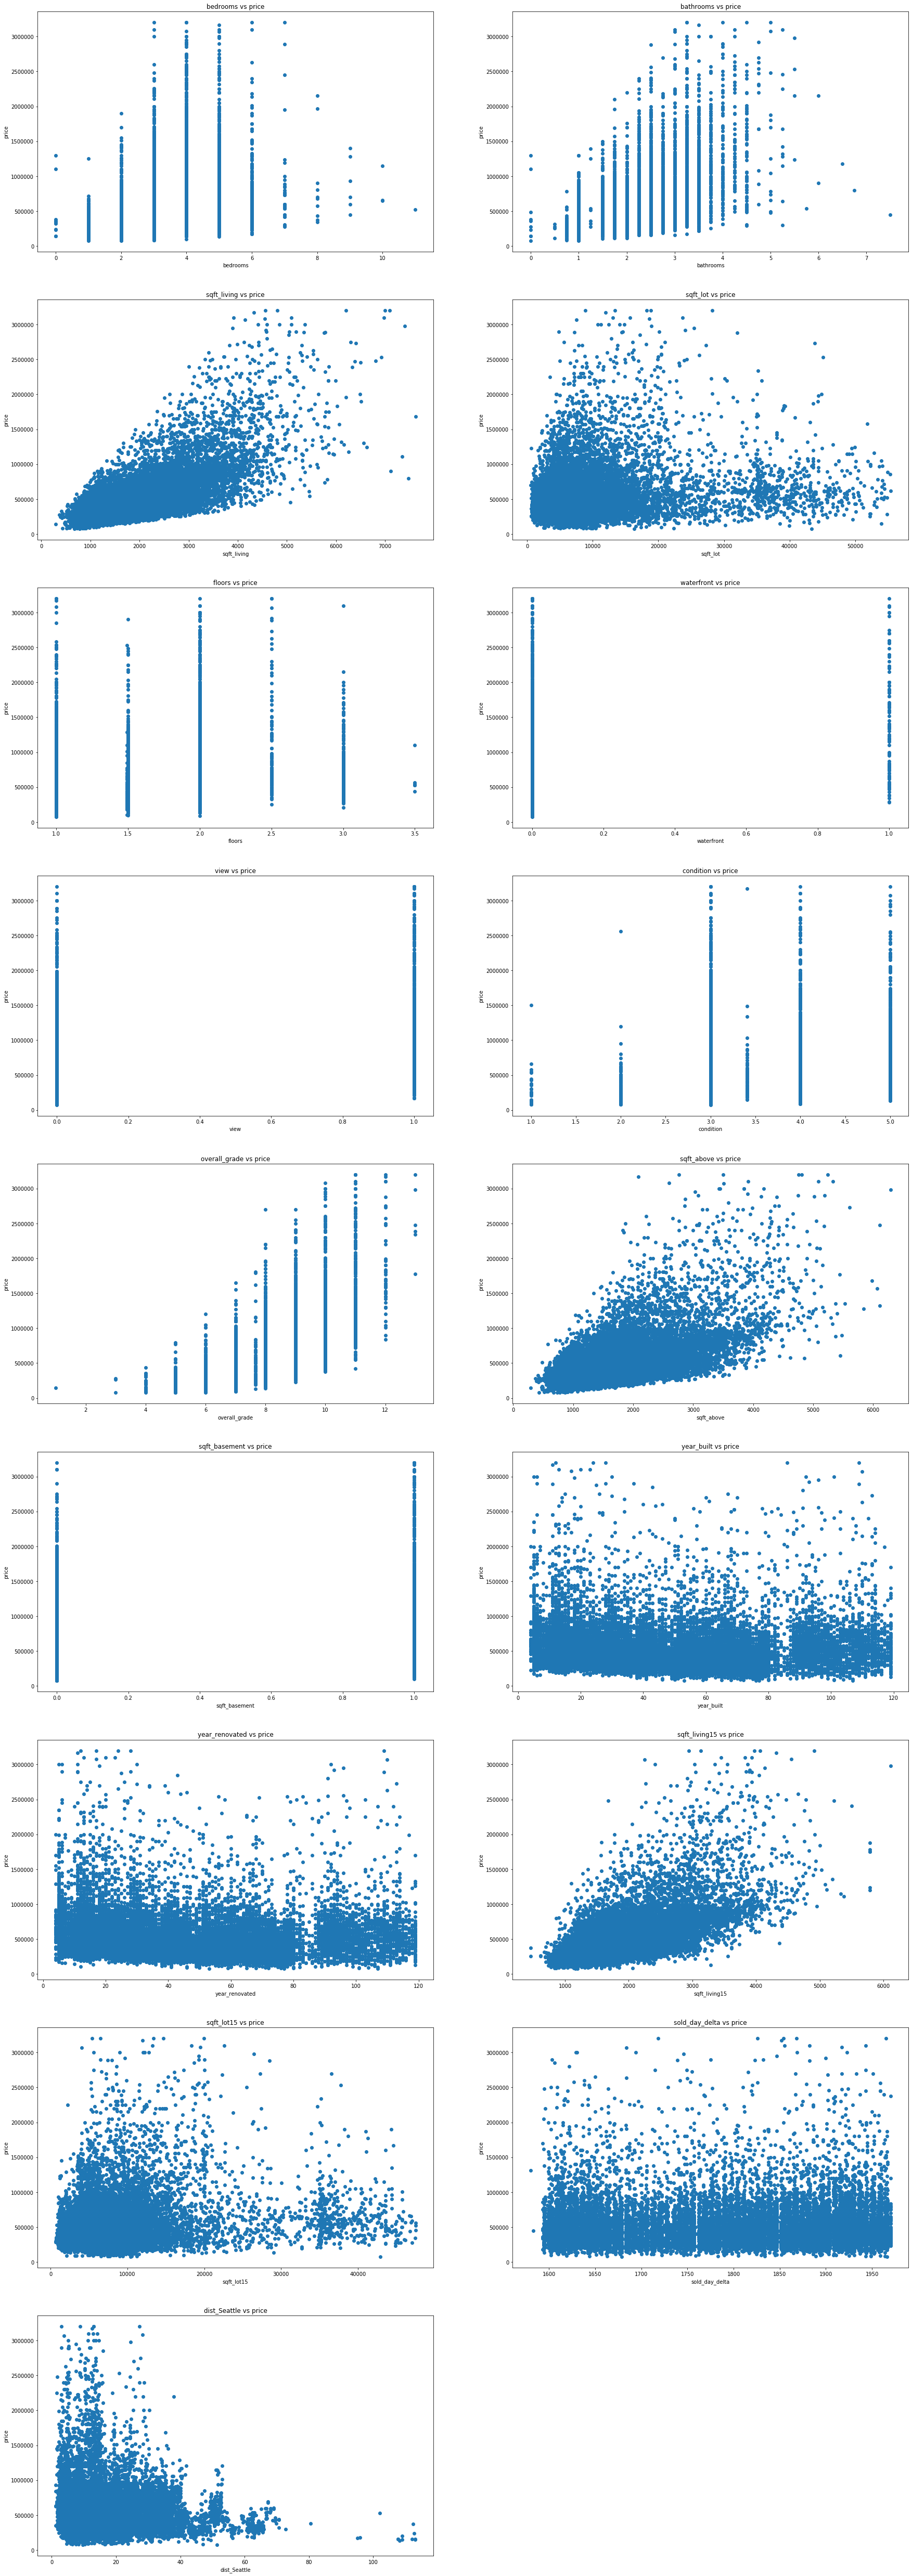

In [21]:
subplot_scatter(house, TARGET)

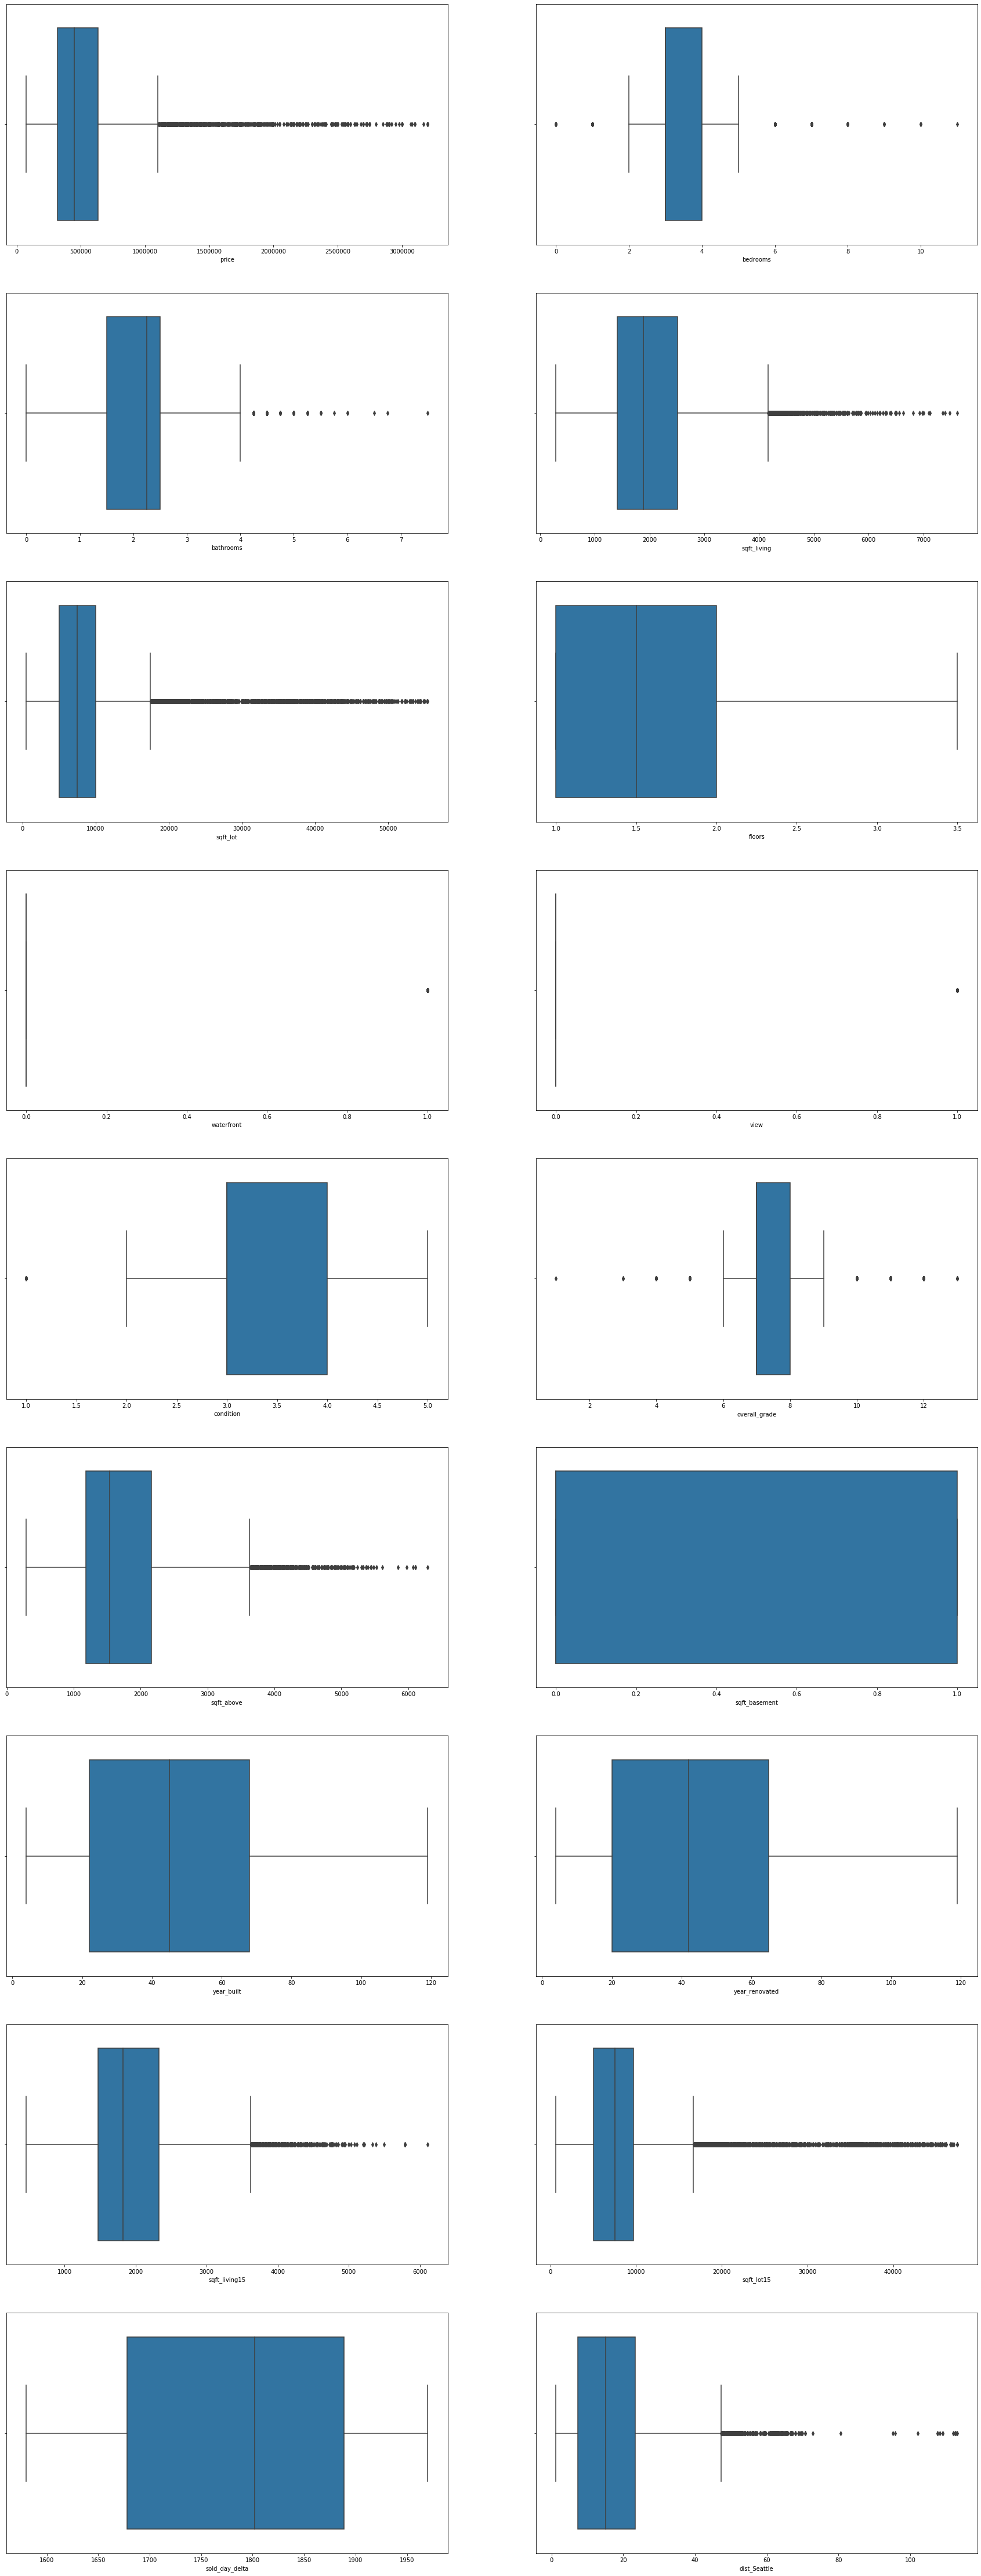

In [22]:
subplot_box(house)

In [23]:
# house.corr()

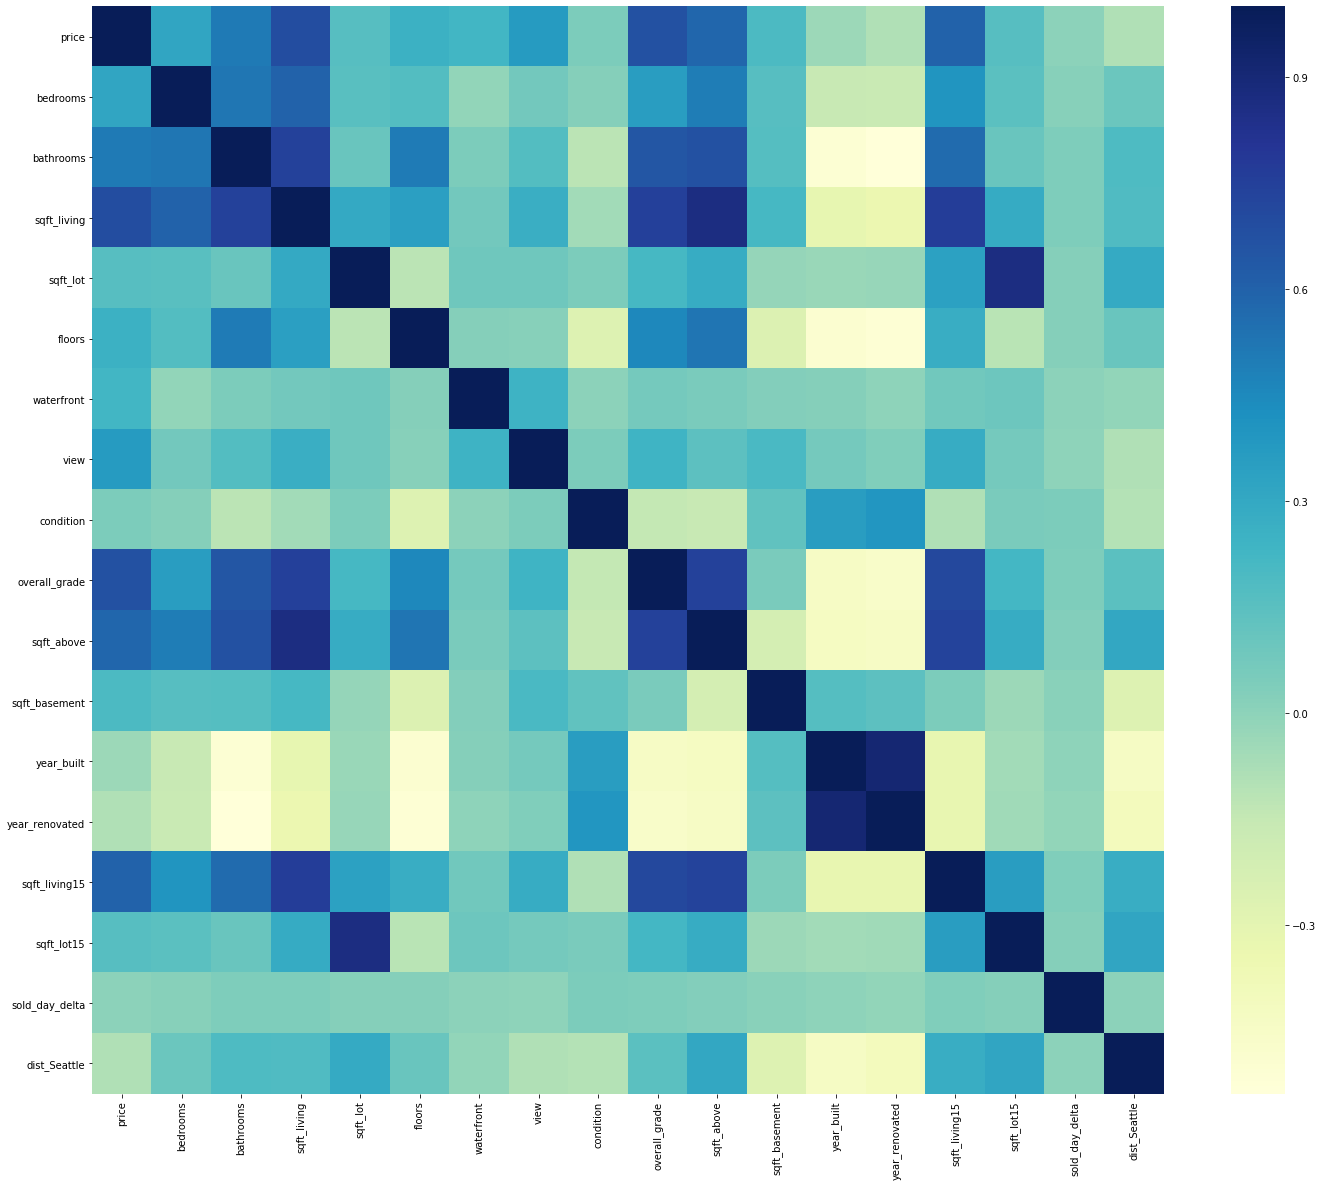

In [24]:
plt.figure(figsize=(24, 20))
ax = sns.heatmap(house.corr(), cmap="YlGnBu")

# Task 2

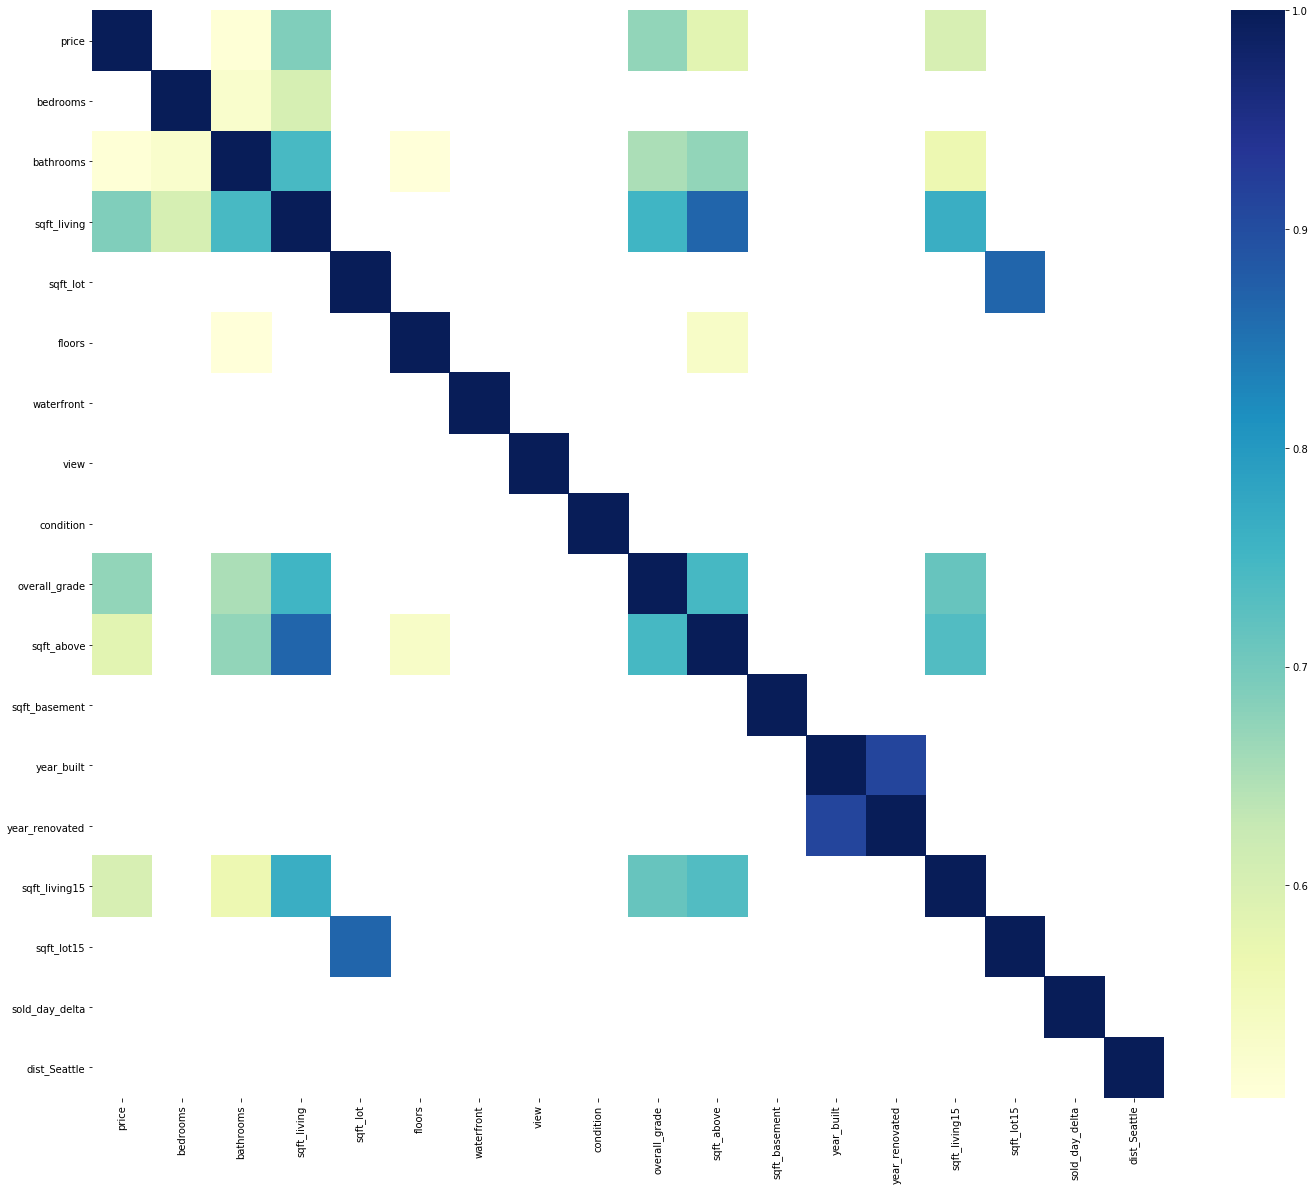

In [25]:
plt.figure(figsize=(24, 20))
sns.heatmap(house.corr()[house.corr()>0.5], cmap="YlGnBu")

In [26]:
# house.corr()["sqft_lot15"]["sqft_lot"]
# house.corr()["sqft_living15"]["sqft_living"]
# house.corr()["year_renovated"]["year_built"]
# house.corr()["overall_grade"].sort_values(ascending=False)

In [27]:
print(abs(house.corr()[TARGET]).sort_values(ascending=False))

price             1.000000
sqft_living       0.687603
overall_grade     0.672895
sqft_living15     0.601123
sqft_above        0.584446
bathrooms         0.508189
view              0.370490
bedrooms          0.316740
floors            0.260019
waterfront        0.225442
sqft_basement     0.195523
sqft_lot          0.164405
sqft_lot15        0.159569
dist_Seattle      0.091787
year_renovated    0.089111
condition         0.049862
year_built        0.034597
sold_day_delta    0.004910
Name: price, dtype: float64


In [28]:
def evaluate_linear_regression(y_test, y_pred, sample_size, variable_size):
    MSE = mean_squared_error(y_test,y_pred)
    RMSE = sqrt(MSE)
    R_square = r2_score(y_test,y_pred)
    
    Adj_R_square = 1-(1-R_square)*(sample_size-1)/(sample_size-variable_size-1)

    print("Mean Squared Error : {0:.3f}".format(MSE))
    print("RMSE : {0:.3f}".format(RMSE))
    print("R^2 : {0:.3f}".format(R_square))
    print("Adj_R_square: {0:.3f}".format(Adj_R_square))


def Plot_resid(y_test, y_pred):
    """
    
    """
    
    resid = y_test-y_pred
    
    plt.figure(figsize = (16,9))
    plt.scatter(y_pred,resid)
    plt.axhline(0,0,1, color="g", ls="--")
    plt.xlabel("Fitted")
    plt.ylabel("Residual")
    plt.title("Residual Plot")
    plt.savefig("Residual plot ols")
    plt.show()

def train_and_predict(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    ols = LinearRegression(fit_intercept=True)
    reg = ols.fit(X_train, y_train)

    print("Coef of the regression: ", reg.coef_)
    print("Intercept of the regression: ", reg.intercept_)

    y_pred = ols.predict(X_test)
    
    return y_test, y_pred
    


def linear_regression(df, selected_features, TARGET):
    
    X = df[selected_features]
    y = df[TARGET]
    y_test, y_pred = train_and_predict(X, y)  
    evaluate_linear_regression(y_test, y_pred, len(X), len(df.columns))
    Plot_resid(y_test, y_pred)

Coef of the regression:  [1.13376314e+02 3.82531858e+04 1.31944476e+05]
Intercept of the regression:  -779080.492765073
Mean Squared Error : 58800329812.706
RMSE : 242487.793
R^2 : 0.501
Adj_R_square: 0.501


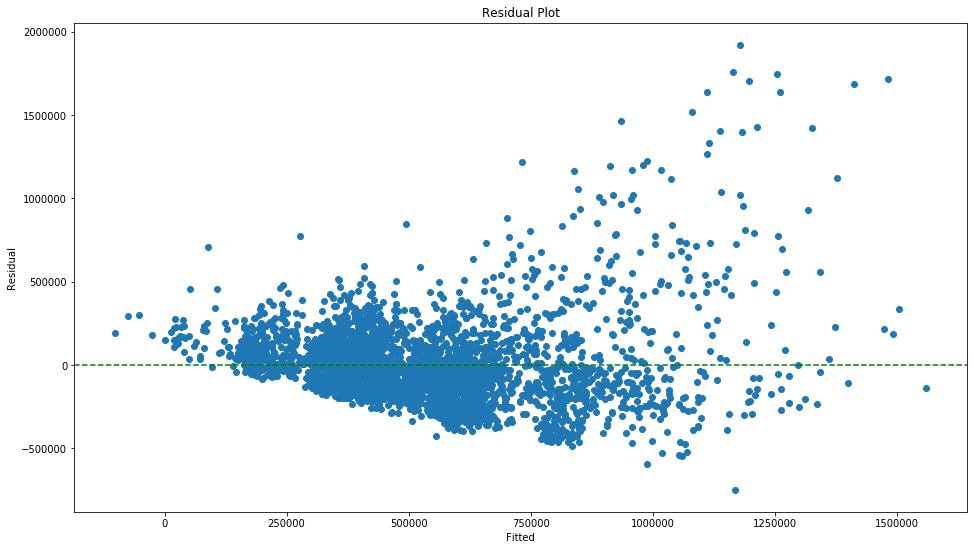

In [29]:
selected_features = ["sqft_living15", "bathrooms", "overall_grade"]
linear_regression(house, selected_features, TARGET)

# Task 3

In [30]:

get_status(house)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,overall_grade,sqft_above,sqft_basement,year_built,year_renovated,sqft_living15,sqft_lot15,sold_day_delta,dist_Seattle
median,4.470000e+05,3.000,2.250,1890.000,7.439000e+03,1.500,0.000,0.000,3.000,7.000,1540.000,0.000,45.000,42.000,1820.000,7.500000e+03,1802.000,15.050
mad,2.267850e+05,0.733,0.608,673.142,4.622166e+03,0.487,0.013,0.175,0.559,0.906,613.941,0.479,24.713,24.262,526.492,3.922387e+03,98.527,9.603
var,1.127416e+11,0.824,0.566,753130.606,5.684328e+07,0.292,0.006,0.087,0.424,1.306,612538.341,0.239,872.123,842.374,452767.417,4.288294e+07,12777.130,151.860
std,3.357701e+05,0.908,0.752,867.831,7.539448e+03,0.541,0.080,0.296,0.651,1.143,782.648,0.489,29.532,29.024,672.880,6.548506e+03,113.036,12.323
skew,2.693000e+00,0.541,0.371,1.131,2.843000e+00,0.637,12.272,2.729,1.044,0.734,1.217,0.423,0.440,0.526,1.108,2.955000e+00,-0.166,1.412
kurt,1.135800e+01,2.033,0.578,2.090,9.852000e+00,-0.438,148.628,5.450,0.550,1.166,1.581,-1.822,-0.694,-0.574,1.567,1.084800e+01,-1.284,3.343


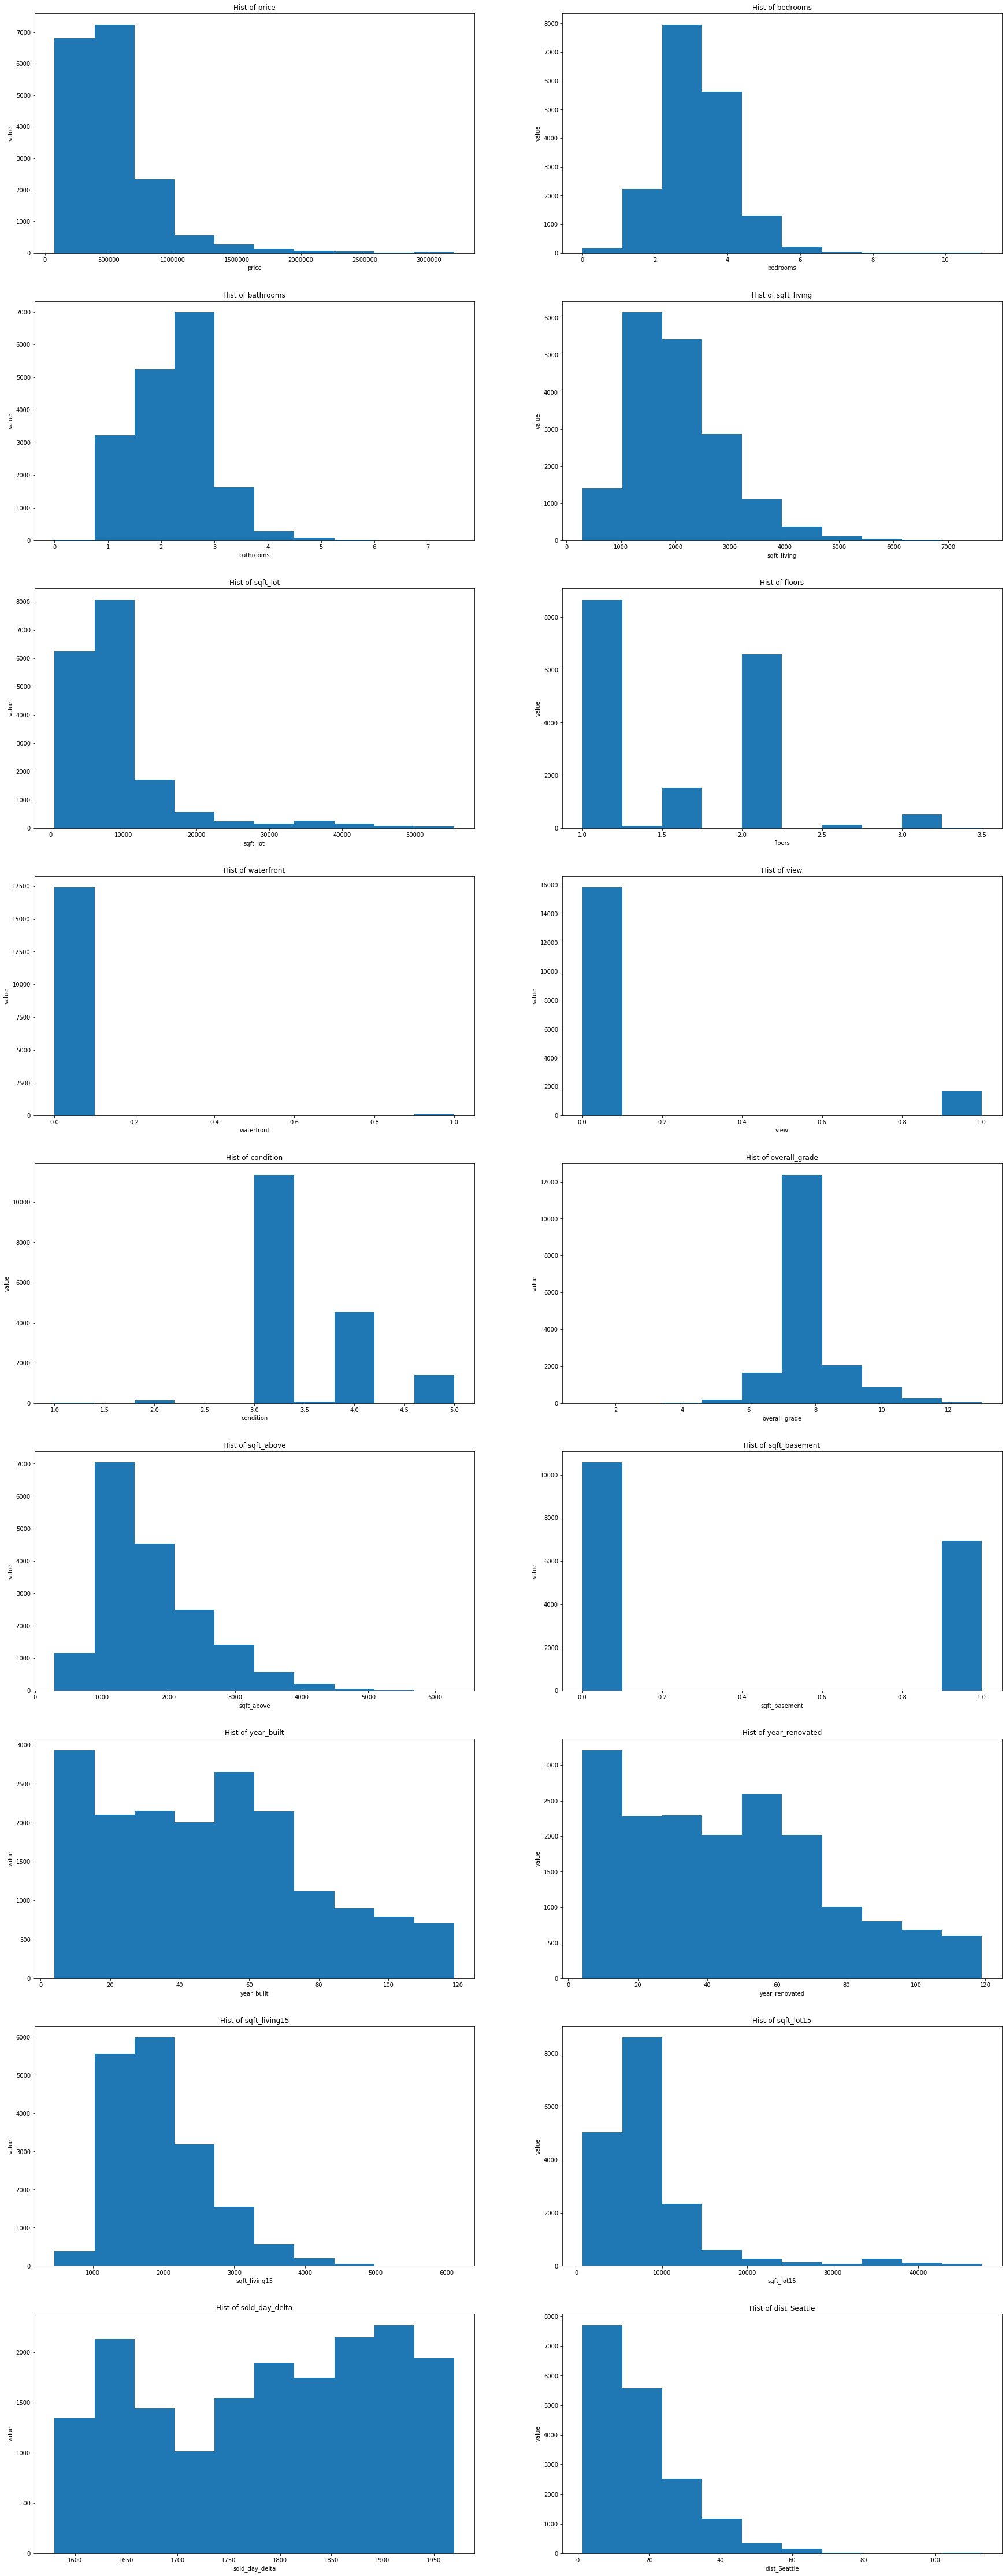

In [31]:
def _hist(df, col):
    
    plt.hist(house[col], bins=10)
    plt.xlabel(col)
    plt.ylabel("value")
        
    items = ["Hist of ", col]
    title = ''.join(items)
    plt.title(title)


def subplot_hist(df):
    plt.figure(figsize=(30,90))
    num_subplot = len(df.columns)
    for i, col in enumerate(house.columns):
        plt.subplot(num_subplot//2 + 1,2,i+1)
        _hist(df, col)
        
subplot_hist(house)

In [32]:
high_skew_cols = ["price","sqft_living", "sqft_above", "sqft_living15", "dist_Seattle",]
cols = ["sqft_lot", "sqft_lot15"]
for col in high_skew_cols:
    house[col] = np.log(house[col])
    
for col in cols:
    house[col] = np.log(house[col])   

In [33]:
get_status(house)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,overall_grade,sqft_above,sqft_basement,year_built,year_renovated,sqft_living15,sqft_lot15,sold_day_delta,dist_Seattle
median,13.010,3.000,2.250,7.544,8.914,1.500,0.000,0.000,3.000,7.000,7.340,0.000,45.000,42.000,7.507,8.923,1802.000,2.711
mad,0.412,0.733,0.608,0.336,0.509,0.487,0.013,0.175,0.559,0.906,0.342,0.479,24.713,24.262,0.264,0.461,98.527,0.637
var,0.272,0.824,0.566,0.174,0.498,0.292,0.006,0.087,0.424,1.306,0.175,0.239,872.123,842.374,0.105,0.411,12777.130,0.556
std,0.522,0.908,0.752,0.417,0.706,0.541,0.080,0.296,0.651,1.143,0.418,0.489,29.532,29.024,0.325,0.641,113.036,0.746
skew,0.362,0.541,0.371,-0.082,-0.263,0.637,12.272,2.729,1.044,0.734,0.223,0.423,0.440,0.526,0.222,-0.256,-0.166,-0.184
kurt,0.414,2.033,0.578,-0.156,1.256,-0.438,148.628,5.450,0.550,1.166,-0.407,-1.822,-0.694,-0.574,-0.215,1.525,-1.284,-0.725


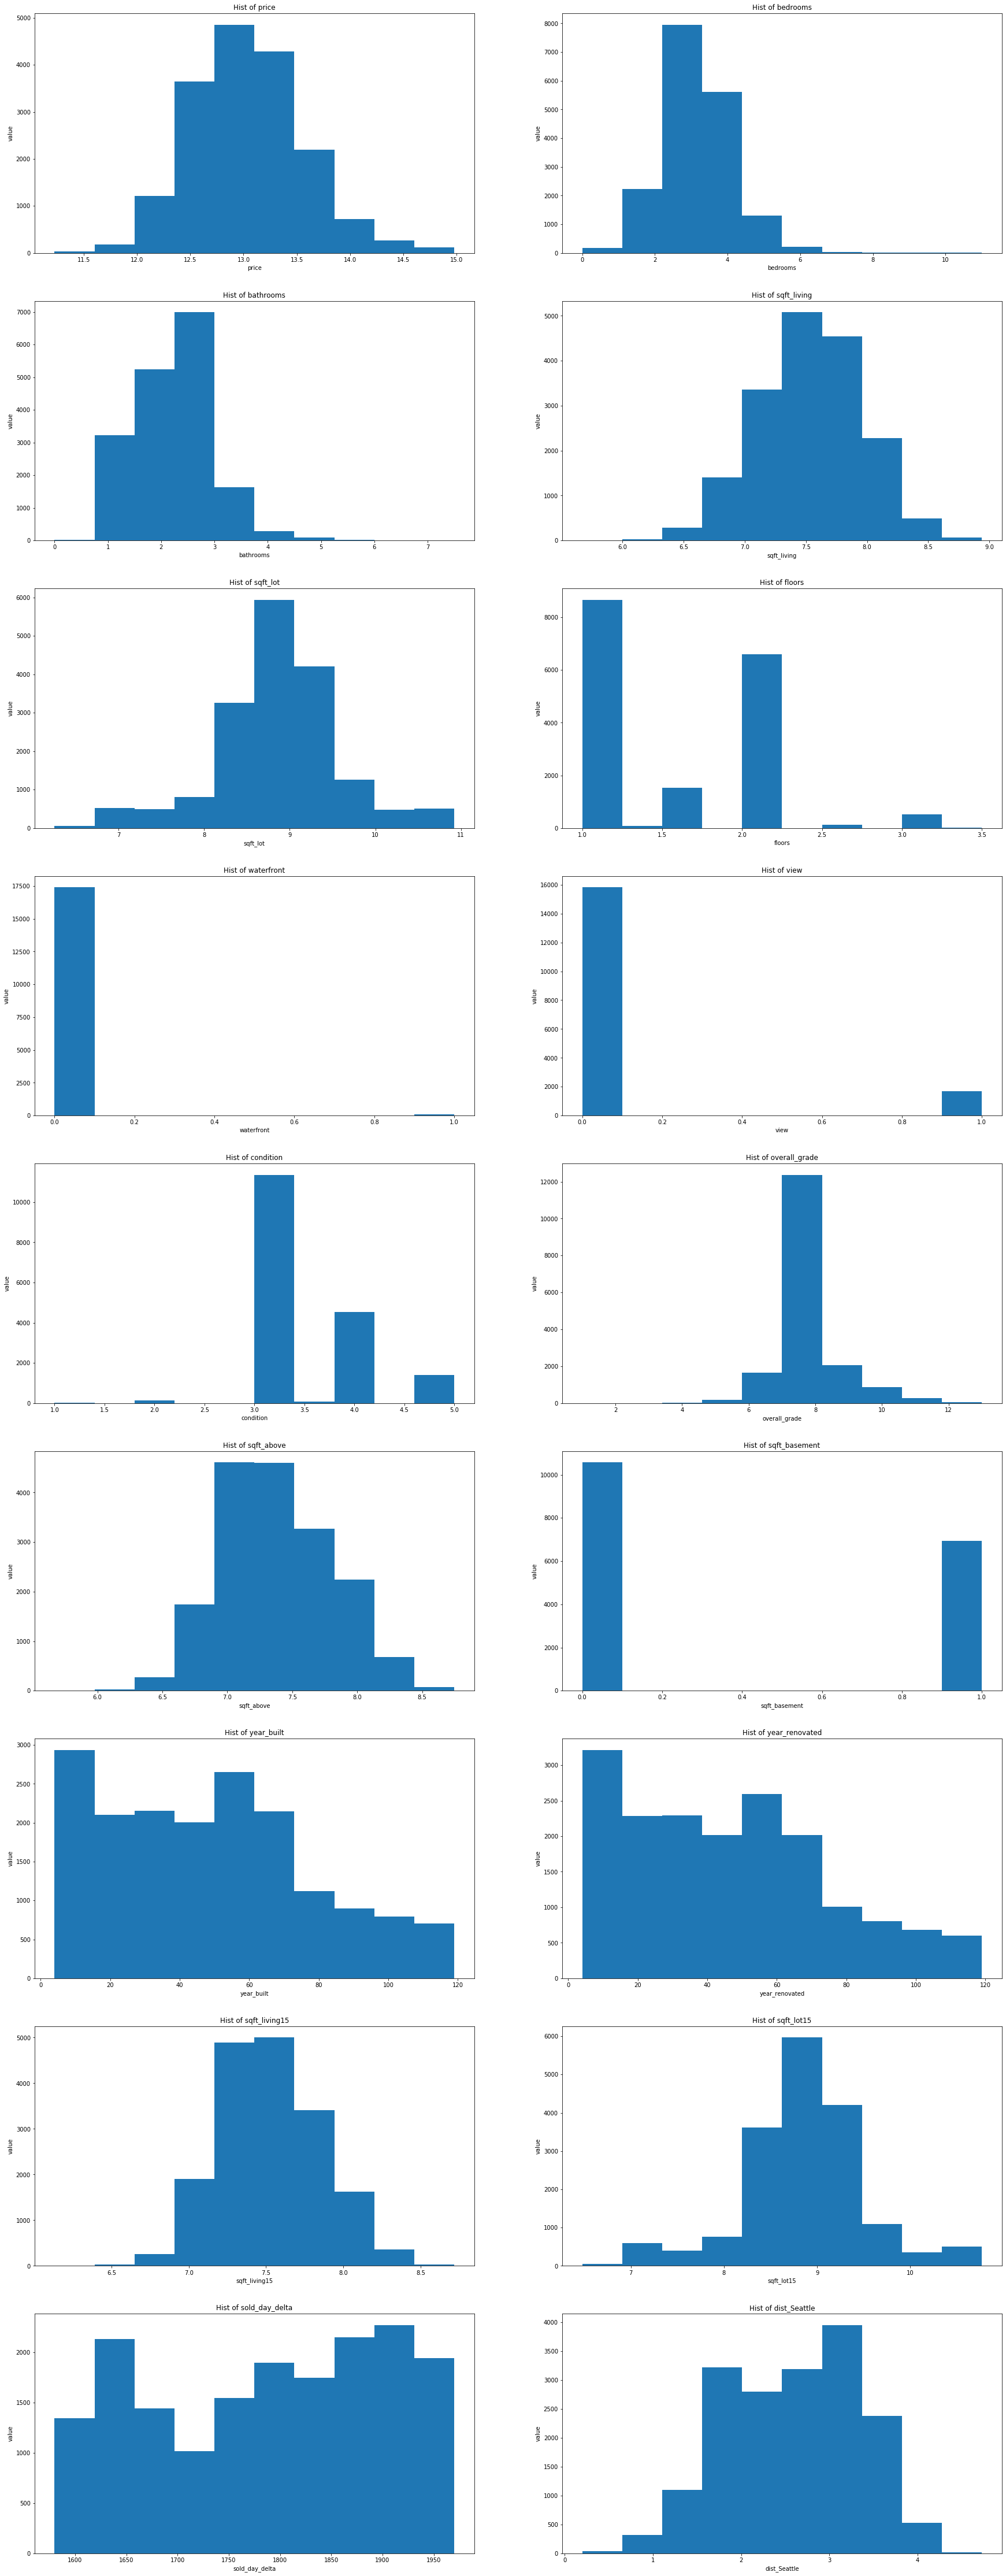

In [34]:
subplot_hist(house)

In [35]:
# scaler = MinMaxScaler()
# house = pd.DataFrame(scaler.fit_transform(house), columns=house.columns)

In [36]:
get_status(house)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,overall_grade,sqft_above,sqft_basement,year_built,year_renovated,sqft_living15,sqft_lot15,sold_day_delta,dist_Seattle
median,13.010,3.000,2.250,7.544,8.914,1.500,0.000,0.000,3.000,7.000,7.340,0.000,45.000,42.000,7.507,8.923,1802.000,2.711
mad,0.412,0.733,0.608,0.336,0.509,0.487,0.013,0.175,0.559,0.906,0.342,0.479,24.713,24.262,0.264,0.461,98.527,0.637
var,0.272,0.824,0.566,0.174,0.498,0.292,0.006,0.087,0.424,1.306,0.175,0.239,872.123,842.374,0.105,0.411,12777.130,0.556
std,0.522,0.908,0.752,0.417,0.706,0.541,0.080,0.296,0.651,1.143,0.418,0.489,29.532,29.024,0.325,0.641,113.036,0.746
skew,0.362,0.541,0.371,-0.082,-0.263,0.637,12.272,2.729,1.044,0.734,0.223,0.423,0.440,0.526,0.222,-0.256,-0.166,-0.184
kurt,0.414,2.033,0.578,-0.156,1.256,-0.438,148.628,5.450,0.550,1.166,-0.407,-1.822,-0.694,-0.574,-0.215,1.525,-1.284,-0.725


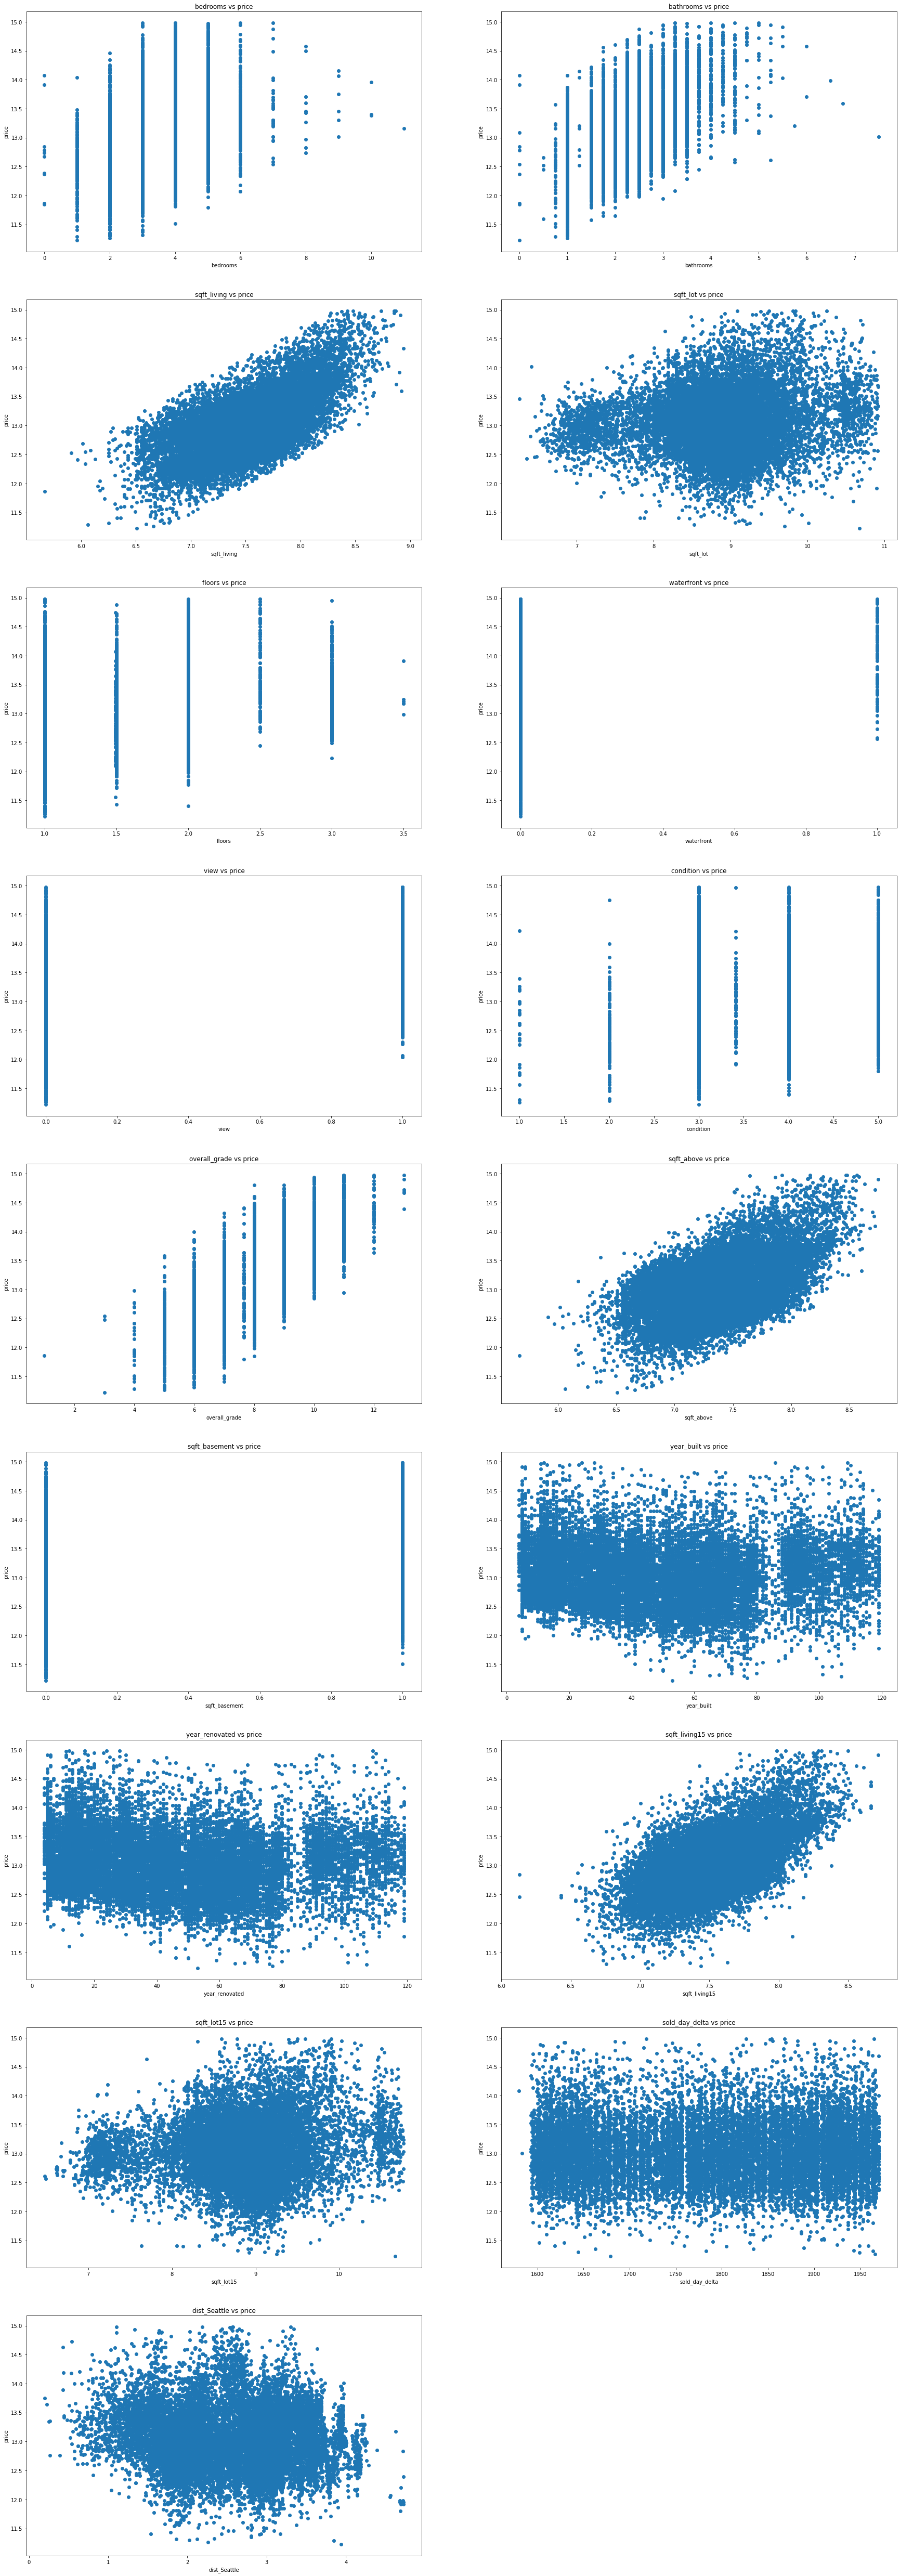

In [37]:
subplot_scatter(house, TARGET)

In [38]:
house.corr()[TARGET].sort_values(ascending=False)

price             1.000000
overall_grade     0.691859
sqft_living       0.662797
sqft_living15     0.602390
sqft_above        0.567688
bathrooms         0.532585
bedrooms          0.342326
view              0.335365
floors            0.301957
sqft_basement     0.224205
waterfront        0.156162
sqft_lot          0.102317
sqft_lot15        0.094078
condition         0.047851
sold_day_delta    0.005844
year_built       -0.059736
year_renovated   -0.110786
dist_Seattle     -0.115554
Name: price, dtype: float64

In [39]:

all_features = house.columns.drop(TARGET)
selected_features = all_features

Coef of the regression:  [-3.64504492e-02  6.31459953e-02  2.17615094e-01 -1.40193990e-02
  1.29178672e-02  5.02292337e-01  8.22238430e-02  6.12544010e-02
  1.86761959e-01  1.59516595e-01  6.02681794e-02  4.68349293e-03
 -9.09664332e-04  3.47294672e-01 -4.45510842e-02 -1.70393143e-04
 -1.35203105e-01]
Intercept of the regression:  6.894941512543646
Mean Squared Error : 0.089
RMSE : 0.298
R^2 : 0.677
Adj_R_square: 0.677


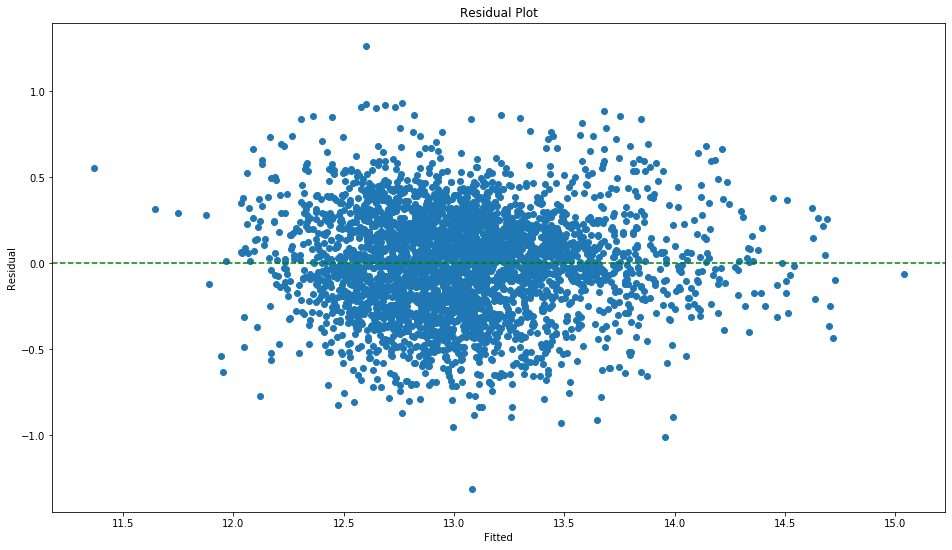

In [40]:
linear_regression(house, selected_features, TARGET)

In [41]:
house

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,overall_grade,sqft_above,sqft_basement,year_built,year_renovated,sqft_living15,sqft_lot15,sold_day_delta,dist_Seattle
0,12.601487,2,1.50,7.265430,7.408531,3.000000,0.0,0,3.0,7.000000,7.265430,0.0,20,20,7.265430,7.408531,1790,2.119464
1,14.272935,4,3.25,8.448914,10.855840,2.000000,0.0,0,4.0,12.000000,8.448914,0.0,31,31,8.349957,10.623155,1872,2.924448
2,13.239435,2,0.75,7.272398,8.216088,1.000000,0.0,0,3.0,7.000000,7.090077,1.0,105,105,7.272398,8.366370,1916,1.686623
3,13.355853,2,1.00,7.029973,7.878534,1.000000,0.0,0,4.0,8.000000,7.029973,0.0,92,92,7.426549,8.070906,1917,1.319109
4,13.567049,4,2.50,8.064636,9.169831,2.000000,0.0,1,3.0,9.000000,8.064636,0.0,17,17,7.799753,9.633056,1611,2.449861
5,13.091904,3,2.50,7.408531,8.142063,2.000000,0.0,0,3.0,7.000000,7.408531,0.0,16,16,7.426549,8.144969,1629,3.499158
6,12.736701,3,2.75,7.450080,10.239960,1.000000,0.0,0,4.0,7.000000,7.450080,0.0,61,61,7.600902,10.641058,1671,2.988478
7,12.723693,3,2.50,7.839132,8.433812,2.000000,0.0,0,3.0,8.000000,7.839132,0.0,6,6,7.851661,8.476371,1903,3.235887
8,12.959844,4,2.50,7.807917,8.601534,2.000000,0.0,0,3.0,9.000000,7.807917,0.0,16,16,7.807917,8.541691,1630,3.222817
9,13.102161,5,3.50,8.402904,7.997999,3.000000,0.0,1,3.0,10.000000,8.095599,1.0,4,4,7.820038,8.350194,1952,1.536759
